In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from abc import ABC, abstractmethod
import time, functools


class Optimizator(ABC):
    
    def __init__(
        self, loss_function, gradient, init_vector, learning_rate=1e-3, 
        max_iter=1000, tolerance=1e-3, display_time=False, *args, **kwargs,
    ):
        self.loss_function = loss_function
        self.gradient = gradient
        self.init_vector = np.array(init_vector)
        self.learning_rate = learning_rate
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.display_time = display_time
        
    def _compute_time(function):
        @functools.wraps(function)
        def wrapper(self, *args, **kwargs):
            start = time.time()
            result = function(self, *args, **kwargs)
            delta = time.time() - start
            if self.display_time == True:
                print(f"Function worked for {delta * 1000:.1f} ms seconds")
            return result
        return wrapper

    @_compute_time
    @abstractmethod
    def optimize(self):
        pass
        
        
class GradientDescent(Optimizator):
    
    def __init__(
        self, loss_function, gradient, init_vector, learning_rate=1e-3, 
        max_iter=1000, tolerance=1e-3, *args, **kwargs,
    ):
        super().__init__(loss_function, gradient, init_vector, learning_rate, max_iter, tolerance, *args, **kwargs)
        
    @Optimizator._compute_time
    def optimize(self):
        vector = self.init_vector
        losses = []
        vector_logs = []
        for _ in range(self.max_iter):
            vector_logs.append(vector)
            losses.append(self.loss_function(vector))
            
            diff = self.learning_rate * self.gradient(vector)
            vector = vector - diff
            
            if np.mean(np.abs(diff)) < self.tolerance:
                print("Delta is less then tolerance. Success stopping")
                break
                
        self.losses = np.array(losses)
        self.vector_logs = np.array(vector_logs)
        self.vector = vector
        return vector
    
    
class Adam(Optimizator):
    
    def __init__(
        self, loss_function, gradient, init_vector, learning_rate=1e-3, 
        max_iter=2000, tolerance=1e-3, betas=(0.9, 0.999), epsilon=1e-8, *args, **kwargs,
    ):
        super().__init__(loss_function, gradient, init_vector, learning_rate, max_iter, tolerance, *args, **kwargs,)
        self.betas = betas
        self.epsilon = epsilon
        
    @Optimizator._compute_time
    def optimize(self, display_time=True):
        vector = self.init_vector
        losses = []
        vector_logs = []
        
        first_moment = 0
        second_moment = 0
        for t in range(self.max_iter):
            
            losses.append(self.loss_function(vector))
            vector_logs.append(vector)
            
            grad = self.gradient(vector)
            first_moment = self.betas[0] * first_moment + (1 - self.betas[0]) * grad
            second_moment = self.betas[1] * second_moment + (1 - self.betas[1]) * grad**2
            
            first_moment_hat = first_moment / (1 - self.betas[0]**(t + 1))
            second_moment_hat = second_moment / (1 - self.betas[1]**(t + 1))
            
            vector = vector - self.learning_rate * first_moment_hat / (np.sqrt(second_moment_hat) + self.epsilon)
            
            if np.mean(np.abs(first_moment_hat / (np.sqrt(second_moment_hat) + self.epsilon))) < self.tolerance:
                print("Delta is less then tolerance. Success stopping")
                break
            
        self.vector = vector
        self.losses = np.array(losses)
        self.vector_logs = np.array(vector_logs)
        return vector
    
    
def rosenbrock(x):
    """The Rosenbrock function"""
    return np.sum(100.0 * (x[1 : ] - x[ : -1]**2.0)**2.0 + (1 - x[ : -1])**2.0, axis=0)

def rosenbrock_grad(x):
    """Gradient of Rosenbrock function"""
    xm = x[1 : -1]
    xm_m1 = x[ : -2]
    xm_p1 = x[2 : ]
    der = np.zeros_like(x)
    der[1 : -1] = 200 * (xm - xm_m1**2) - 400 * (xm_p1 - xm**2)*xm - 2 * (1 - xm)
    der[0] = -400 * x[0] * (x[1] - x[0]**2) - 2 * (1 - x[0])
    der[-1] = 200 * (x[-1] - x[-2]**2)
    return der

Delta is less then tolerance. Success stopping
Function worked for 2.0 ms seconds


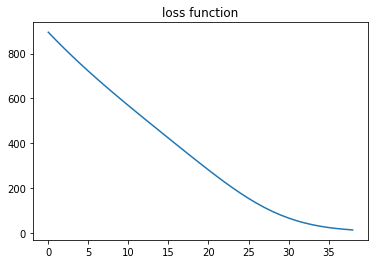

In [50]:
init_x = np.array([-0.1, 3], dtype = float)
gd = GradientDescent(rosenbrock, rosenbrock_grad, init_x, learning_rate=1e-4, tolerance=1e-2, display_time=True)
gd.optimize()
plt.title('loss function')
plt.plot(gd.losses)
plt.show()

Delta is less then tolerance. Success stopping
Function worked for 12.0 ms seconds


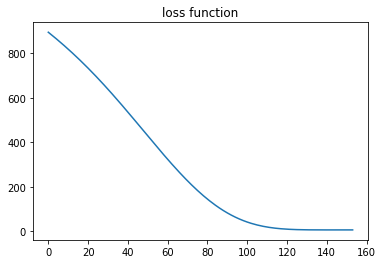

In [51]:
init_x = np.array([-0.1, 3], dtype = float)
adam = Adam(rosenbrock, rosenbrock_grad, init_x, learning_rate=1e-2, tolerance=1e-2, display_time=True)
adam.optimize()
plt.title('loss function')
plt.plot(adam.losses)
plt.show()

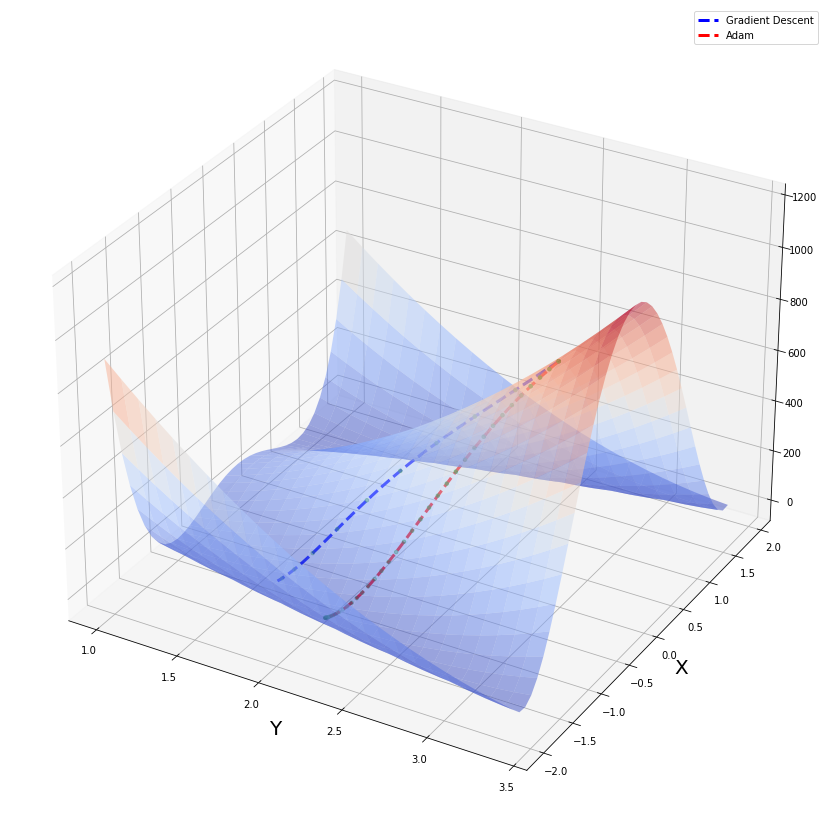

In [53]:
X = np.arange(-2, 2, 0.1)
Y = np.arange(1, 3.5, 0.1)
X, Y = np.meshgrid(X, Y)
Z = rosenbrock(np.array([X,Y]))

fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(Y, X, Z, cmap=cm.coolwarm, alpha=0.5)

ax.scatter(gd.vector_logs[::4, 1], gd.vector_logs[::4, 0], zs = gd.losses[::4], lw=1, c='g', s=50, marker='.')
ax.plot(gd.vector_logs[:, 1], gd.vector_logs[:, 0], '--b', zs = gd.losses, lw=3, label='Gradient Descent')
 
ax.scatter(adam.vector_logs[::4, 1], adam.vector_logs[::4, 0], zs = adam.losses[::4], lw=1, c='g', s=50, marker='.')
ax.plot(adam.vector_logs[:, 1], adam.vector_logs[:, 0], '--r', zs = adam.losses, lw=3, label='Adam')

ax.set_xlabel('Y', fontsize=20)
ax.set_ylabel('X', fontsize=20)
plt.legend()
plt.show()